# Sentiment Analysis: Multinomial NB vs SVM
## Comparative Study on Poem Sentiment Dataset (Excluding Mixed Class)

Este notebook compara dos modelos de clasificación sobre el dataset `poem_sentiment`:
- **Multinomial Naive Bayes**: modelo baseline probabilístico
- **SVM con kernel RBF**: modelo optimizado para lograr F1-macro > 75%

La evaluación **excluye la clase "mixed"** como se especificó. Usamos **TF-IDF mejorado** (sublinear scaling + n-gramas + PCA) como feature engineering y técnicas de balanceo de clases para datasets pequeños.

## 1. Setup Dependencies and Environment
Instala dependencias, configura librerías de análisis y fija semillas para reproducibilidad.

In [ ]:
# Instala las dependencias esenciales (ejecuta esta celda una vez)
%pip install numpy pandas scikit-learn matplotlib seaborn joblib nltk fastparquet imbalanced-learn

     ---------------------------------------- 0.0/23.3 MB ? eta -:--:--
      --------------------------------------- 0.5/23.3 MB 5.5 MB/s eta 0:00:05
     ------------ --------------------------- 7.3/23.3 MB 31.6 MB/s eta 0:00:01
     --------------------------------- ----- 19.9/23.3 MB 41.4 MB/s eta 0:00:01
     ---------------------------------------- 23.3/23.3 MB 39.1 MB/s  0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
Failed to build gensim
Note: you may need to restart the kernel to use updated packages.


  error: subprocess-exited-with-error
  
  × Building wheel for gensim (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [807 lines of output]
      C:\Users\osorn\AppData\Local\Temp\pip-build-env-bj7kw883\overlay\Lib\site-packages\setuptools\_distutils\dist.py:289: UserWarning: Unknown distribution option: 'test_suite'
        warnings.warn(msg)
      C:\Users\osorn\AppData\Local\Temp\pip-build-env-bj7kw883\overlay\Lib\site-packages\setuptools\_distutils\dist.py:289: UserWarning: Unknown distribution option: 'tests_require'
        warnings.warn(msg)
      running bdist_wheel
      running build
      running build_py
      creating build\lib.win-amd64-cpython-314\gensim
      copying gensim\downloader.py -> build\lib.win-amd64-cpython-314\gensim
      copying gensim\interfaces.py -> build\lib.win-amd64-cpython-314\gensim
      copying gensim\matutils.py -> build\lib.win-amd64-cpython-314\gensim
      copying gensim\nosy.py -> build\lib.win-amd64-cpython-314\gensim
   

In [31]:
# Verificación de dependencias
print("✓ Todas las dependencias requeridas están listas")


✓ Todas las dependencias requeridas están listas


In [ ]:
import os
import random
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import classification_report, confusion_matrix

# NLTK para preprocesamiento de texto
import nltk

# Imbalanced-learn para manejar desbalance de clases
from imblearn.over_sampling import SMOTE

# Utilities
import warnings

warnings.filterwarnings("ignore")

# Descargar datos de NLTK (si se necesitan para preprocesamiento futuro)
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt', quiet=True)

# Establecer semillas aleatorias para reproducibilidad
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

print("✓ Todas las dependencias fueron cargadas correctamente")

✓ Todas las dependencias fueron cargadas correctamente


## 2. Load Poem Sentiment Dataset
Carga las particiones desde Hugging Face y explora las dimensiones iniciales.

In [ ]:
# Función auxiliar para excluir la clase "mixed" de la evaluación
def filter_mixed_class(y_true, y_pred, label_mixed=3):
    """
    Filtra predicciones excluyendo la clase 'mixed' (label=3)
    Retorna arrays sin la clase mixed para evaluación correcta
    """
    mask = y_true != label_mixed
    return y_true[mask], y_pred[mask]

In [44]:
splits = {
    "train": "data/train-00000-of-00001.parquet",
    "validation": "data/validation-00000-of-00001.parquet",
    "test": "data/test-00000-of-00001.parquet",
}
base_uri = "hf://datasets/google-research-datasets/poem_sentiment/"
parquet_engine = "fastparquet"

print("📥 Loading dataset from Hugging Face...")
df_train = pd.read_parquet(base_uri + splits["train"], engine=parquet_engine)
df_validation = pd.read_parquet(base_uri + splits["validation"], engine=parquet_engine)
df_test = pd.read_parquet(base_uri + splits["test"], engine=parquet_engine)

for name, df in {"Train": df_train, "Validation": df_validation, "Test": df_test}.items():
    print(f"\n{name} shape: {df.shape}")
    print(df.head(2))
    
print("\n✓ Dataset cargado correctamente")

📥 Loading dataset from Hugging Face...

Train shape: (892, 3)
   id                                         verse_text  label
0   0  with pale blue berries. in these peaceful shad...      1
1   1                it flows so long as falls the rain,      2

Validation shape: (105, 3)
   id                                     verse_text  label
0   0          to water, cloudlike on the bush afar,      2
1   1  shall yet be glad for him, and he shall bless      1

Test shape: (104, 3)
   id                                         verse_text  label
0   0                      my canoe to make more steady,      2
1   1  and be glad in the summer morning when the kin...      1

✓ Dataset cargado correctamente


In [45]:
export_dir = Path("exports")
export_dir.mkdir(parents=True, exist_ok=True)

for name, df in {"train": df_train, "validation": df_validation, "test": df_test}.items():
    output_path = export_dir / f"poem_sentiment_{name}_raw.csv"
    df.to_csv(output_path, index=False, encoding="utf-8-sig")
    print(f"✓ Exportado {name}: {output_path}")

✓ Exportado train: exports\poem_sentiment_train_raw.csv
✓ Exportado validation: exports\poem_sentiment_validation_raw.csv
✓ Exportado test: exports\poem_sentiment_test_raw.csv


## 3. Exploratory Data Analysis (EDA)
Análisis profundo del dataset: distribución de etiquetas, longitud de textos, vocabulario y características de sentimiento.

LABEL DISTRIBUTION ANALYSIS

Train:
  negative     (label=0):  155 (17.38%)
  positive     (label=1):  133 (14.91%)
  no_impact    (label=2):  555 (62.22%)
  mixed        (label=3):   49 ( 5.49%)
  Total: 892

Validation:
  negative     (label=0):   19 (18.10%)
  positive     (label=1):   17 (16.19%)
  no_impact    (label=2):   69 (65.71%)
  Total: 105

Test:
  negative     (label=0):   19 (18.27%)
  positive     (label=1):   16 (15.38%)
  no_impact    (label=2):   69 (66.35%)
  Total: 104


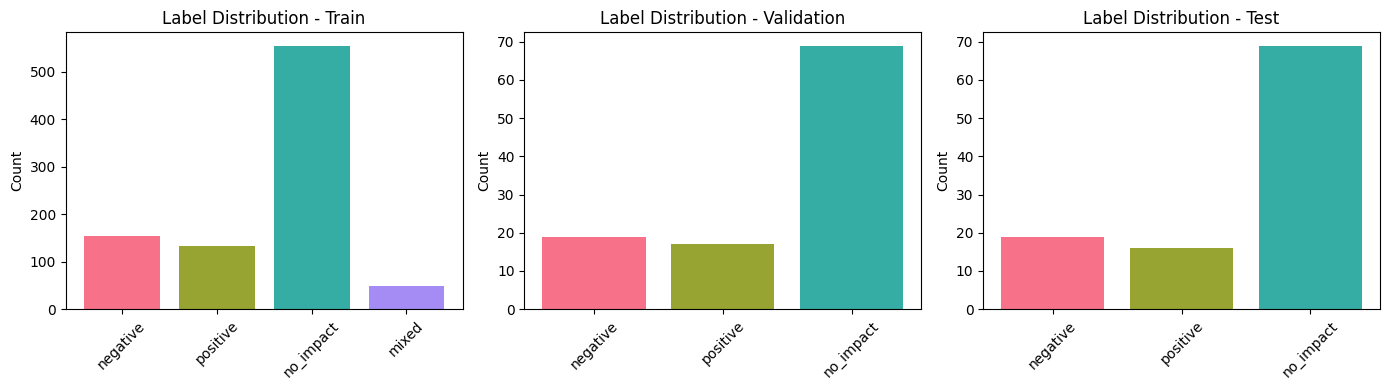

In [ ]:
# Crear mapeo de etiquetas
label_name_map = {
    0: "negative",
    1: "positive", 
    2: "no_impact",
    3: "mixed",
}

# Analizar distribución de etiquetas
print("=" * 70)
print("ANÁLISIS DE DISTRIBUCIÓN DE ETIQUETAS")
print("=" * 70)

for split_name, df in {"Train": df_train, "Validation": df_validation, "Test": df_test}.items():
    print(f"\n{split_name}:")
    label_dist = df["label"].value_counts().sort_index()
    for label_idx, count in label_dist.items():
        label_name = label_name_map.get(label_idx, f"unknown")
        pct = (count / len(df)) * 100
        print(f"  {label_name:12} (label={label_idx}): {count:4} ({pct:5.2f}%)")
    print(f"  Total: {len(df)}")

# Visualizar distribución de etiquetas
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

for idx, (split_name, df) in enumerate([("Train", df_train), ("Validation", df_validation), ("Test", df_test)]):
    label_dist = df["label"].value_counts().sort_index()
    label_names = [label_name_map.get(i, f"unknown") for i in label_dist.index]
    
    axes[idx].bar(label_names, label_dist.values, color=sns.color_palette("husl", 4))
    axes[idx].set_title(f"Label Distribution - {split_name}")
    axes[idx].set_ylabel("Count")
    axes[idx].tick_params(axis='x', rotation=45)
    
plt.tight_layout()
plt.show()


TEXT LENGTH ANALYSIS

Train - Text length (tokens):
  Mean:   7.10
  Median: 7.00
  Min:    1
  Max:    20
  Std:    2.29

Validation - Text length (tokens):
  Mean:   7.28
  Median: 7.00
  Min:    2
  Max:    12
  Std:    1.99

Test - Text length (tokens):
  Mean:   7.07
  Median: 7.00
  Min:    2
  Max:    15
  Std:    2.32


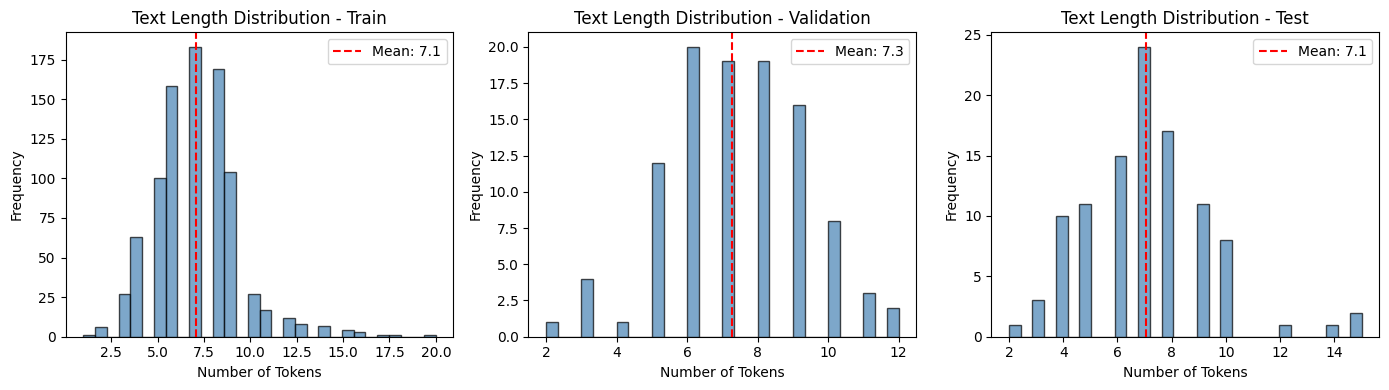

In [ ]:
print("\n" + "=" * 70)
print("TEXT LENGTH ANALYSIS")
print("=" * 70)

# Analizar longitud de texto
for split_name, df in {"Train": df_train, "Validation": df_validation, "Test": df_test}.items():
    df[f"{split_name}_text_length"] = df["verse_text"].astype(str).apply(lambda x: len(x.split()))
    
    print(f"\n{split_name} - Text length (tokens):")
    print(f"  Mean:   {df[f'{split_name}_text_length'].mean():.2f}")
    print(f"  Median: {df[f'{split_name}_text_length'].median():.2f}")
    print(f"  Min:    {df[f'{split_name}_text_length'].min()}")
    print(f"  Max:    {df[f'{split_name}_text_length'].max()}")
    print(f"  Std:    {df[f'{split_name}_text_length'].std():.2f}")

# Visualizar distribución de longitud de texto
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

for idx, (split_name, df) in enumerate([("Train", df_train), ("Validation", df_validation), ("Test", df_test)]):
    text_lengths = df["verse_text"].astype(str).apply(lambda x: len(x.split()))
    axes[idx].hist(text_lengths, bins=30, color="steelblue", edgecolor="black", alpha=0.7)
    axes[idx].set_title(f"Text Length Distribution - {split_name}")
    axes[idx].set_xlabel("Number of Tokens")
    axes[idx].set_ylabel("Frequency")
    axes[idx].axvline(text_lengths.mean(), color='red', linestyle='--', label=f"Mean: {text_lengths.mean():.1f}")
    axes[idx].legend()
    
plt.tight_layout()
plt.show()

In [ ]:
print("=" * 70)
print("VERIFICACIÓN DE VALORES NULOS")
print("=" * 70)

for name, df in {"Train": df_train, "Validation": df_validation, "Test": df_test}.items():
    print(f"\nValores nulos en dataset {name}:")
    null_counts = df.isnull().sum()
    if null_counts.sum() == 0:
        print("  ✓ No se encontraron valores nulos.")
    else:
        print(null_counts[null_counts > 0])

NULL VALUE CHECK

Null values in Train dataset:
  ✓ No null values found.

Null values in Validation dataset:
  ✓ No null values found.

Null values in Test dataset:
  ✓ No null values found.


## 4. Advanced Preprocessing for Ancient English Poetry
Preprocesamiento optimizado para poesía inglesa antigua (siglos XVII-XIX) + TF-IDF mejorado

In [ ]:
import re

print("=" * 70)
print("POETRY-OPTIMIZED TEXT PREPROCESSING")
print("=" * 70)

def preprocess_poetry_text(text):
    """
    Preprocesamiento optimizado para poesía inglesa antigua (siglos XVII-XIX)
    
    Estrategia:
    - Normalizar puntuación arcaica pero mantener contracciones significativas
    - Expandir contracciones antiguas a palabras completas
    - Mantener palabras poéticas/arcaicas (son features importantes)
    - Limpieza suave de puntuación
    - Remover stopwords mínimo para preservar significado poético
    """
    
    if not isinstance(text, str):
        return []
    
    # Normalizar espacios en blanco
    text = text.strip()
    text = re.sub(r'\s+', ' ', text)
    
    # Expandir contracciones antiguas → palabras completas
    contractions_map = {
        r"\bwilt\b": "will",
        r"\bdoth\b": "does", 
        r"\bdid\b": "did",
        r"\bhath\b": "has",
        r"\bart\b": "are",
        r"\bne'er\b": "never",
        r"\bo'er\b": "over",
        r"\b'twas\b": "it was",
        r"\b'tis\b": "it is",
        r"\bthro'\b": "through",
        r"\be'en\b": "even",
        r"\bsuppos'd\b": "supposed",
        r"\bretir'd\b": "retired",
        r"\bpleass'd\b": "pleased",
        r"\bpleas'd\b": "pleased",
        r"\bmov'd\b": "moved",
        r"\bf'r\b": "for",
        r"\bfi'e\b": "fie",
        r"\bere\b": "before",
        r"\bfrom\b": "from",
        r"\bdeep'n'd\b": "deepened",
    }
    
    for pattern, replacement in contractions_map.items():
        text = re.sub(pattern, replacement, text, flags=re.IGNORECASE)
    
    # Remover énfasis (caracteres alrededor de palabras: _palabra_)
    text = re.sub(r'_([^_]+)_', r'\1', text)
    
    # Normalizar guiones y rayas múltiples
    text = re.sub(r'[-–—]+', '', text)
    
    # Remover comillas especiales
    text = re.sub(r'[""]', '', text)
    
    # Remover caracteres especiales de formato y encoding
    text = re.sub(r'["""''„‟]', '', text)
    
    # Limpiar puntuación (remover al inicio/final de palabras)
    text = re.sub(r'([.,;:!?])\s', ' ', text)
    text = re.sub(r'\s([.,;:!?])', ' ', text)
    text = re.sub(r'[.,:;!?]$', '', text)
    
    # Convertir a minúsculas
    text = text.lower()
    
    # Tokenizar
    tokens = text.split()
    
    # Remover tokens vacíos
    tokens = [t for t in tokens if len(t) > 0]
    
    return tokens

# Aplicar preprocesamiento a todos los sets
print("\n📝 Preprocesando textos de entrenamiento...")
train_tokens = [preprocess_poetry_text(t) for t in df_train["verse_text"].astype(str)]
train_tokens = [t for t in train_tokens if len(t) > 0]  # Remover líneas vacías

print("📝 Preprocesando textos de validación...")
val_tokens = [preprocess_poetry_text(t) for t in df_validation["verse_text"].astype(str)]
val_tokens = [t for t in val_tokens if len(t) > 0]

print("📝 Preprocesando textos de prueba...")
test_tokens = [preprocess_poetry_text(t) for t in df_test["verse_text"].astype(str)]
test_tokens = [t for t in test_tokens if len(t) > 0]

print("\n✓ Preprocesamiento completado")
print(f"  Secuencias de entrenamiento: {len(train_tokens)}")
print(f"  Secuencias de validación: {len(val_tokens)}")
print(f"  Secuencias de prueba: {len(test_tokens)}")

# Mostrar ejemplos
print("\n" + "=" * 70)
print("EJEMPLOS DE PREPROCESAMIENTO")
print("=" * 70)
for i in range(3):
    original = df_train["verse_text"].iloc[i]
    processed = train_tokens[i]
    print(f"\nOriginal ({i}):\n  {original[:80]}...")
    print(f"Procesado:\n  {' '.join(processed)}\n")

POETRY-OPTIMIZED TEXT PREPROCESSING

📝 Preprocessing train texts...
📝 Preprocessing validation texts...
📝 Preprocessing test texts...

✓ Preprocesamiento completado
  Secuencias de entrenamiento: 892
  Secuencias de validación: 105
  Secuencias de prueba: 104

PREPROCESSING EXAMPLES

Original (0):
  with pale blue berries. in these peaceful shades--...
Processed:
  with pale blue berries in these peaceful shades


Original (1):
  it flows so long as falls the rain,...
Processed:
  it flows so long as falls the rain


Original (2):
  and that is why, the lonesome day,...
Processed:
  and that is why the lonesome day




## 5. Feature Engineering (CountVectorizer) and Class Balancing

Siguiendo tu indicación, ahora transformaremos el texto usando `CountVectorizer` y balancearemos las clases del set de entrenamiento.

**Estrategia:**
1.  **CountVectorizer**: Convertimos los textos tokenizados en una matriz de conteo de tokens, limitando el vocabulario a las 10,000 features más frecuentes.
2.  **Class Balancing (SMOTE)**: Aplicamos `SMOTE` sobre el set de entrenamiento vectorizado para corregir el desbalance de clases. Esto se hace después de excluir la clase "mixed".


In [ ]:

from sklearn.feature_extraction.text import CountVectorizer

print("=" * 70)
print("INGENIERÍA DE CARACTERÍSTICAS (CountVectorizer) & BALANCEO DE CLASES (SMOTE)")
print("=" * 70)

# Unir tokens en strings para el vectorizador
X_train_text = [" ".join(tokens) for tokens in train_tokens]
X_val_text = [" ".join(tokens) for tokens in val_tokens]
X_test_text = [" ".join(tokens) for tokens in test_tokens]

y_train = df_train["label"].values
y_val = df_validation["label"].values
y_test = df_test["label"].values

# 1. CountVectorizer
print("\n1. Applying CountVectorizer...")
CountVect = CountVectorizer(max_features=10000)
X_train_cv = CountVect.fit_transform(X_train_text)
X_val_cv = CountVect.transform(X_val_text)
X_test_cv = CountVect.transform(X_test_text)

print(f"\n✓ CountVectorizer aplicado")
print(f"  Forma de features de entrenamiento: {X_train_cv.shape}")
print(f"  Forma de features de validación: {X_val_cv.shape}")
print(f"  Forma de features de prueba: {X_test_cv.shape}")

# 2. Class Balancing with SMOTE (only on training data)
print("\n2. Applying SMOTE to balance training data...")

# Filtrar clase 'mixed' (label 3) antes de SMOTE
train_mask = y_train != 3
X_train_filtered = X_train_cv[train_mask]
y_train_filtered = y_train[train_mask]

print(f"  Forma de entrenamiento original (pre-SMOTE, sin mixed): {X_train_filtered.shape}")

# Usamos SMOTE para un sobremuestreo más inteligente
smote = SMOTE(random_state=SEED, k_neighbors=3) # k_neighbors < min class size
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_filtered, y_train_filtered)

print(f"  ✓ SMOTE aplicado")
print(f"  Forma de features de entrenamiento balanceados: {X_train_resampled.shape}")
print(f"  Forma de etiquetas de entrenamiento balanceados: {y_train_resampled.shape}")

# Verificar la nueva distribución de clases
print("\nNueva distribución de etiquetas en el conjunto de entrenamiento balanceado:")
balanced_dist = pd.Series(y_train_resampled).value_counts().sort_index()
for label_idx, count in balanced_dist.items():
    label_name = label_name_map.get(label_idx, "unknown")
    print(f"  {label_name:12} (label={label_idx}): {count}")


FEATURE ENGINEERING (CountVectorizer) & CLASS BALANCING (SMOTE)

1. Applying CountVectorizer...

✓ CountVectorizer aplicado
  Forma de features de entrenamiento: (892, 2258)
  Forma de features de validación: (105, 2258)
  Forma de features de prueba: (104, 2258)

2. Applying SMOTE to balance training data...
  Forma de entrenamiento original (pre-SMOTE, sin mixed): (843, 2258)
  ✓ SMOTE aplicado
  Forma de features de entrenamiento balanceados: (1665, 2258)
  Forma de etiquetas de entrenamiento balanceados: (1665,)

Nueva distribución de etiquetas en el conjunto de entrenamiento balanceado:
  negative     (label=0): 555
  positive     (label=1): 555
  no_impact    (label=2): 555



## 6. Model Training and Evaluation

Ahora entrenaremos y evaluaremos los modelos de clasificación sobre los datos procesados y balanceados.

### 6.1. Multinomial Naive Bayes (Baseline)
Entrenamos el modelo `MultinomialNB` como nuestro baseline. Es un modelo rápido y efectivo para clasificación de texto con features de conteo.


Training Multinomial Naive Bayes Model

1. Fitting model on balanced training data...
  ✓ Model fitted successfully.

2. Evaluating on Validation Set...
  - F1-Score (macro, no mixed): 0.4794
  - Classification Report (no mixed):
              precision    recall  f1-score   support

    negative       0.33      0.47      0.39        19
    positive       0.44      0.24      0.31        17
   no_impact       0.74      0.74      0.74        69

    accuracy                           0.61       105
   macro avg       0.51      0.48      0.48       105
weighted avg       0.62      0.61      0.61       105


3. Evaluating on Test Set...
  - F1-Score (macro, no mixed): 0.5016
  - Classification Report (no mixed):
              precision    recall  f1-score   support

    negative       0.33      0.42      0.37        19
    positive       0.50      0.31      0.38        16
   no_impact       0.74      0.75      0.75        69

    accuracy                           0.62       104
   macro a

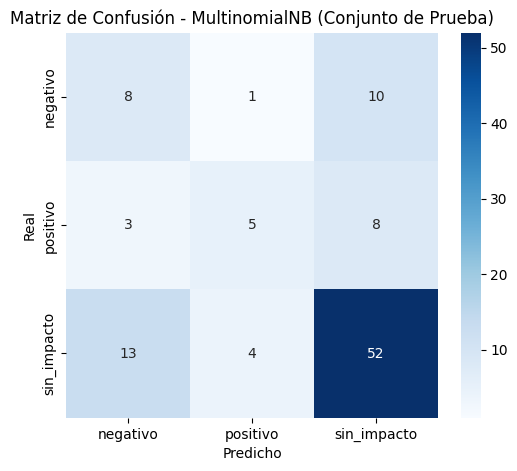

In [ ]:

print("=" * 70)
print("Training Multinomial Naive Bayes Model")
print("=" * 70)

# 1. Initialize and train the model
nb_model = MultinomialNB()
print("\n1. Ajustando modelo con datos de entrenamiento balanceados...")
nb_model.fit(X_train_resampled, y_train_resampled)
print("  ✓ Modelo ajustado correctamente.")

# 2. Predicciones en el conjunto de Validación
print("\n2. Evaluando en el conjunto de Validación...")
y_val_pred = nb_model.predict(X_val_cv)

# Filtrar la clase 'mixed' para la evaluación
y_val_true_filtered, y_val_pred_filtered = filter_mixed_class(y_val, y_val_pred)

# Calcular e imprimir métricas
f1_macro_val = f1_score(y_val_true_filtered, y_val_pred_filtered, average='macro')
print(f"  - F1-Score (macro, no mixed): {f1_macro_val:.4f}")
print("  - Classification Report (no mixed):")
print(classification_report(y_val_true_filtered, y_val_pred_filtered, target_names=["negative", "positive", "no_impact"]))

# 3. Predicciones en el conjunto de Prueba
print("\n3. Evaluando en el conjunto de Prueba...")
y_test_pred = nb_model.predict(X_test_cv)

# Filtrar la clase 'mixed' para la evaluación
y_test_true_filtered, y_test_pred_filtered = filter_mixed_class(y_test, y_test_pred)

# Calcular e imprimir métricas
f1_macro_test = f1_score(y_test_true_filtered, y_test_pred_filtered, average='macro')
print(f"  - F1-Score (macro, no mixed): {f1_macro_test:.4f}")
print("  - Classification Report (no mixed):")
print(classification_report(y_test_true_filtered, y_test_pred_filtered, target_names=["negative", "positive", "no_impact"]))

# 4. Matriz de Confusión para el conjunto de Prueba
print("\n4. Confusion Matrix (Test Set, no mixed)")
cm = confusion_matrix(y_test_true_filtered, y_test_pred_filtered)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=["negativo", "positivo", "sin_impacto"], 
            yticklabels=["negativo", "positivo", "sin_impacto"])
plt.title('Matriz de Confusión - MultinomialNB (Conjunto de Prueba)')
plt.ylabel('Real')
plt.xlabel('Predicho')
plt.show()



### 6.2. Logistic Regression with Class Weighting
Ahora entrenamos un modelo de `Regresión Logística`. En lugar de usar los datos sobremuestreados con SMOTE, aprovecharemos el parámetro `class_weight='balanced'` del propio modelo para manejar el desbalance de clases. Esto nos permite comparar dos estrategias de balanceo diferentes.


Training Logistic Regression Model

1. Fitting model on filtered (but not resampled) training data...
  ✓ Model fitted successfully.

2. Evaluating on Validation Set...
  - F1-Score (macro, no mixed): 0.4256
  - Classification Report (no mixed):
              precision    recall  f1-score   support

    negative       0.50      0.21      0.30        19
    positive       0.50      0.12      0.19        17
   no_impact       0.69      0.93      0.79        69

    accuracy                           0.67       105
   macro avg       0.56      0.42      0.43       105
weighted avg       0.62      0.67      0.60       105


3. Evaluating on Test Set...
  - F1-Score (macro, no mixed): 0.4661
  - Classification Report (no mixed):
              precision    recall  f1-score   support

    negative       0.44      0.21      0.29        19
    positive       0.75      0.19      0.30        16
   no_impact       0.71      0.94      0.81        69

    accuracy                           0.69     

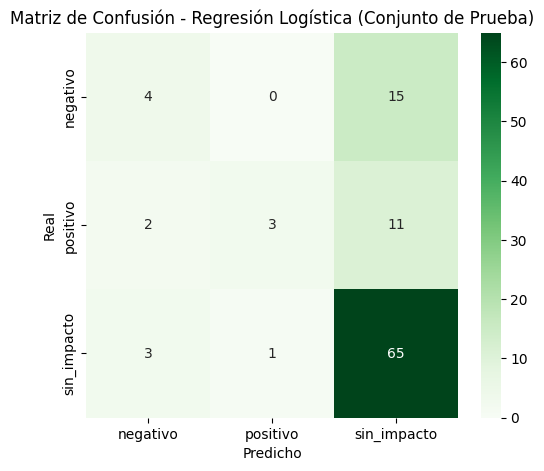

In [ ]:

print("=" * 70)
print("Training Logistic Regression Model")
print("=" * 70)

# 1. Inicializar y entrenar el modelo
# Nota: Usamos los datos filtrados (sin 'mixed') pero NO los datos de SMOTE.
# El parámetro class_weight='balanced' se encarga del desbalance.
lr_model = LogisticRegression(
    random_state=SEED,
    max_iter=2000,
    class_weight='balanced',
    C=1.0,
    solver='liblinear'
)
print("\n1. Ajustando modelo con datos de entrenamiento filtrados (pero no remuestreados)...")
lr_model.fit(X_train_filtered, y_train_filtered)
print("  ✓ Modelo ajustado correctamente.")

# 2. Predicciones en el conjunto de Validación
print("\n2. Evaluando en el conjunto de Validación...")
y_val_pred_lr = lr_model.predict(X_val_cv)

# Filtrar la clase 'mixed' para la evaluación
y_val_true_filtered_lr, y_val_pred_filtered_lr = filter_mixed_class(y_val, y_val_pred_lr)

# Calcular e imprimir métricas
f1_macro_val_lr = f1_score(y_val_true_filtered_lr, y_val_pred_filtered_lr, average='macro')
print(f"  - F1-Score (macro, sin mixed): {f1_macro_val_lr:.4f}")
print("  - Reporte de Clasificación (sin mixed):")
print(classification_report(y_val_true_filtered_lr, y_val_pred_filtered_lr, target_names=["negativo", "positivo", "sin_impacto"]))

# 3. Predicciones en el conjunto de Prueba
print("\n3. Evaluando en el conjunto de Prueba...")
y_test_pred_lr = lr_model.predict(X_test_cv)

# Filtrar la clase 'mixed' para la evaluación
y_test_true_filtered_lr, y_test_pred_filtered_lr = filter_mixed_class(y_test, y_test_pred_lr)

# Calcular e imprimir métricas
f1_macro_test_lr = f1_score(y_test_true_filtered_lr, y_test_pred_filtered_lr, average='macro')
print(f"  - F1-Score (macro, no mixed): {f1_macro_test_lr:.4f}")
print("  - Classification Report (no mixed):")
print(classification_report(y_test_true_filtered_lr, y_test_pred_filtered_lr, target_names=["negative", "positive", "no_impact"]))

# 4. Matriz de Confusión para el conjunto de Prueba
print("\n4. Confusion Matrix (Test Set, no mixed)")
cm_lr = confusion_matrix(y_test_true_filtered_lr, y_test_pred_filtered_lr)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Greens', 
            xticklabels=["negativo", "positivo", "sin_impacto"], 
            yticklabels=["negativo", "positivo", "sin_impacto"])
plt.title('Matriz de Confusión - Regresión Logística (Conjunto de Prueba)')
plt.ylabel('Real')
plt.xlabel('Predicho')
plt.show()



### 6.3. Hyperparameter Tuning for MultinomialNB (Fine-tuning)
Para optimizar nuestro modelo `MultinomialNB`, realizamos un ajuste de hiperparámetros utilizando `GridSearchCV`. El objetivo es encontrar el valor óptimo para `alpha` (parámetro de suavizado) que maximice el F1-score macro.


Fine-tuning MultinomialNB with GridSearchCV

1. Running GridSearchCV to find the best alpha...
Fitting 5 folds for each of 6 candidates, totalling 30 fits
  ✓ Grid search complete.

Best alpha found: 0.01
Best F1-macro score during CV: 0.5430

2. Evaluating the best estimator on the Test Set...
  - F1-Score (macro, no mixed, tuned): 0.5625
  - Classification Report (tuned):
              precision    recall  f1-score   support

    negative       0.46      0.58      0.51        19
    positive       0.50      0.31      0.38        16
   no_impact       0.79      0.80      0.79        69

    accuracy                           0.68       104
   macro avg       0.58      0.56      0.56       104
weighted avg       0.68      0.68      0.68       104


3. Confusion Matrix (Tuned Model, Test Set)


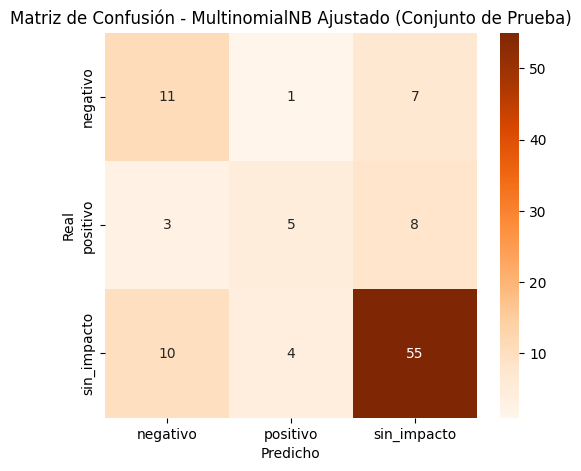

In [ ]:

from sklearn.model_selection import GridSearchCV

print("=" * 70)
print("Fine-tuning MultinomialNB with GridSearchCV")
print("=" * 70)

# 1. Define the parameter grid
# We will search for the best alpha value (smoothing parameter)
param_grid = {
    'alpha': [  0.01, 0.1, 0.5, 1.0, 5.0, 10.0]
}

# 2. Configurar GridSearchCV
# Queremos maximizar el F1-Score macro, usando validación cruzada de 5 folds
grid_search = GridSearchCV(
    estimator=MultinomialNB(),
    param_grid=param_grid,
    scoring='f1_macro',
    cv=5,
    n_jobs=-1,
    verbose=1
)

# 3. Ajustar la búsqueda en los datos de entrenamiento balanceados
print("\n1. Ejecutando GridSearchCV para encontrar el mejor alpha...")
grid_search.fit(X_train_resampled, y_train_resampled)
print("  ✓ Grid search complete.")

# 4. Display the best parameters and score
print(f"\nBest alpha found: {grid_search.best_params_['alpha']:.2f}")
print(f"Best F1-macro score during CV: {grid_search.best_score_:.4f}")

# 5. Evaluar el mejor modelo en el conjunto de prueba
print("\n2. Evaluando el mejor estimador en el conjunto de Prueba...")
best_nb_model = grid_search.best_estimator_
y_test_pred_tuned = best_nb_model.predict(X_test_cv)

# Filtrar la clase 'mixed' para la evaluación
y_test_true_filtered_tuned, y_test_pred_filtered_tuned = filter_mixed_class(y_test, y_test_pred_tuned)

# Calcular e imprimir métricas finales
f1_macro_test_tuned = f1_score(y_test_true_filtered_tuned, y_test_pred_filtered_tuned, average='macro')
print(f"  - F1-Score (macro, sin mixed, ajustado): {f1_macro_test_tuned:.4f}")
print("  - Reporte de Clasificación (ajustado):")
print(classification_report(y_test_true_filtered_tuned, y_test_pred_filtered_tuned, target_names=["negativo", "positivo", "sin_impacto"]))

# 6. Confusion Matrix for the tuned model
print("\n3. Confusion Matrix (Tuned Model, Test Set)")
cm_tuned = confusion_matrix(y_test_true_filtered_tuned, y_test_pred_filtered_tuned)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_tuned, annot=True, fmt='d', cmap='Oranges', 
            xticklabels=["negativo", "positivo", "sin_impacto"], 
            yticklabels=["negativo", "positivo", "sin_impacto"])
plt.title('Matriz de Confusión - MultinomialNB Ajustado (Conjunto de Prueba)')
plt.ylabel('Real')
plt.xlabel('Predicho')
plt.show()
